# MNIST
The MNIST dataset is a set of 60,000 handwritten numbers with their labels. This exercise will use this dataset as a way to explore how to use PyTorch.

## Libraries
- **PyTorch** 
- **MNIST** for the dataset
- **NumPy** for data manipulation
- **Matplotlib** for visualisation
- **scikit-learn** for metrics

In [23]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(), #Convert to tensor and normalise
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [24]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 60000
Test dataset size: 10000


Visualise the dataset

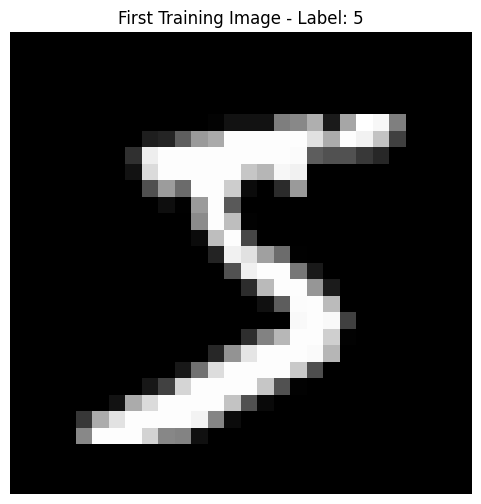

In [25]:
import matplotlib.pyplot as plt
import numpy as np

first_image, first_label = train_dataset[0]
first_image_np = first_image.squeeze().numpy()

plt.figure(figsize=(6,6))
plt.imshow(first_image_np, cmap='grey')
plt.title(f"First Training Image - Label: {first_label}")
plt.axis('off')
plt.show()

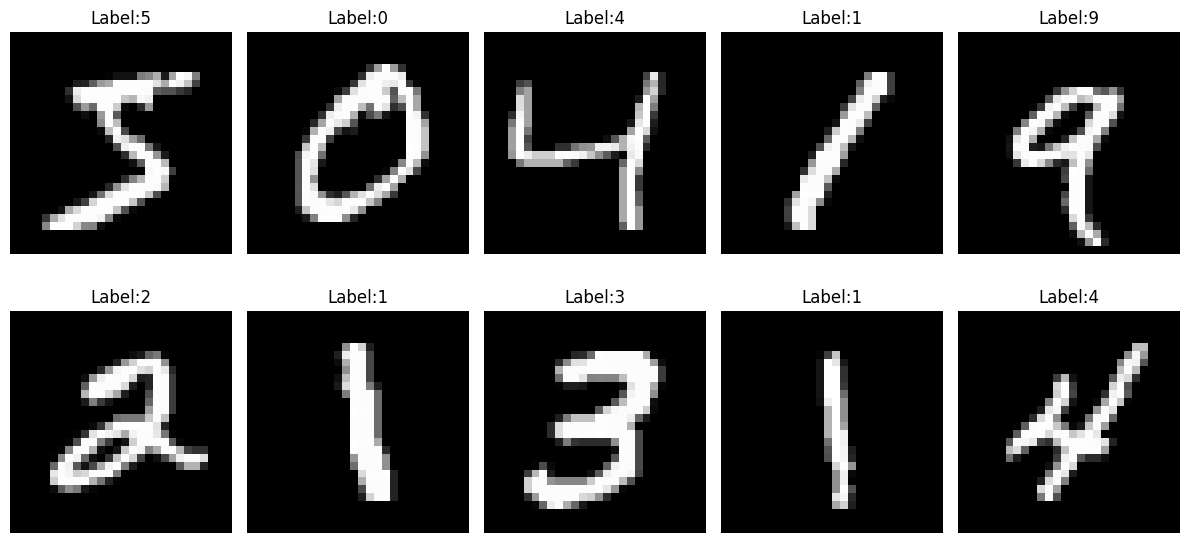

In [26]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i in range(10):
    image, label = train_dataset[i]

    image_np = image.squeeze().numpy()

    row = i // 5
    col = i % 5

    axes[row, col].imshow(image_np, cmap='gray')
    axes[row, col].set_title(f"Label:{label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Data preporation
Neural networks work better with batched data
We can use DataLoader to group images into batches and shuffle them

In [28]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4
)

test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4
)

Neurons!

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()

        # Convert image from 28x28 to a 784 element vector
        self.flatten = nn.Flatten() 
        # Fully connected layer 784in 128out
        self.fc1 = nn.Linear(in_features=784, out_features=128)
        # Fully connected layer 128in 64out
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        # Output layer 64in 10out
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        # Activation function
        self.relu = nn.ReLU()

        # Dropout for regularisation/overfit prevention
        self.dropout = nn.Dropout(p=0.2) # 20% of neurons set to 0

    def forward(self, x):
        x = self.flatten(x)

        # Run through first layer
        x = self.fc1(x)     # Run through first layer
        x = self.relu(x)    # Apply ReLU: negative values become 0
        x = self.dropout(x) # Randomly set some neurons to 0 

        # Second layer
        x = self.fc2(x)
        x = self.relu(x)

        # Output layer
        x = self.fc3(x)

        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)



In [34]:
model = SimpleNeuralNetwork()
print(model)
print(f"Number of parameters:{model.count_parameters()}")

SimpleNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
Number of parameters:109386


In [37]:
# Testing the network works
batch = 5
fake_images = torch.randn(batch, 1, 28, 28)

model.eval()
with torch.no_grad():
    output = model(fake_images)

print(f"Output shape: {output.shape}")
print(f"Output: {output[0]}")
print(f"Prediction: {(torch.argmax(output[0])).item()}")

Output shape: torch.Size([5, 10])
Output: tensor([-0.2360, -0.1772, -0.0257, -0.2500, -0.0325,  0.0195,  0.1699,  0.0418,
         0.1419, -0.0407])
Prediction: 6


## Training Setup
Attributes of training:
1. Loss function - Evaluate how wrong our predictions is
2. Optimiser - How do we update weight to improve

In [49]:
def train_one_epoch(model, train_loader, criterion, optimiser, device, epoch_num):
    # Set model to training mode
    model.train()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    batch_count = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients - effectively reset the optimiser
        optimiser.zero_grad()

        # Forward pass
        outputs = model(images)

        # Loss calculation
        loss = criterion(outputs, labels)   
        loss.backward() # Backward pass

        optimiser.step() # Update weights

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        batch_count += 1

    avg_loss = total_loss / batch_count
    avg_accuracy = total_correct/total_samples

    print(f'    Average Loss: {avg_loss:.4f}')
    print(f'    Average accuracy: {avg_accuracy:.4f} ({total_correct}/{total_samples})')

    return avg_loss, avg_accuracy

def evaluate_model(model, test_loader, criterion, device):
    # Put model in evaluation mode
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    batch_count = 0

    with torch.no_grad():
        for images, labels in test_loader:
            # repeat training steps -- Probably a way to improve this
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            batch_count += 1

    avg_loss = total_loss / batch_count
    avg_accuracy = total_correct/total_samples

    print(f'    Average Loss: {avg_loss:.4f}')
    print(f'    Average accuracy: {avg_accuracy:.4f} ({total_correct}/{total_samples})')

    return avg_loss, avg_accuracy

In [ ]:
import torch.optim as optim

def train(model, train_loader, test_loader, num_epoch=10, learning_rate=0.001):
    # Define the device where the training will take place CPU vs GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimiser
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)
    
    history = {
        'train_loss':[],
        'train_accuracy':[],
        'test_loss':[],
        'test_accuracy': []
    }

    for epoch in range(1, num_epoch + 1):
        print(f"\n{'='*50}")
        print(f"EPOCH {epoch}/{num_epoch}")
        print(f"{'='*50}")

        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimiser, device, epoch
        )

        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_acc)

        print(f"Train → Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"Test  → Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
        if epoch != 1:
            print(f"Accuracy: {(test_acc - history['test_accuracy'][-2]):.4f}")

    print(f"Training complete with final accuracy: {history['test_accuracy'][-1]:.4f}")

    return model, history

In [48]:
trained_model, history = train(model, train_loader, test_loader)


EPOCH 1/10



ZeroDivisionError: float division by zero